In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('loaded', len(results), 'results')

loading ./runs/pure-1-2-30-0-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-0-POSIX/result_summary.txt
loading ./runs/pure-1-2-30-1-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-1-POSIX/result_summary.txt
loading ./runs/pure-1-2-30-2-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-2-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-0-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-0-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-1-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-1-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-2-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-2-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-0-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-0-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-1-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-1-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-2-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-2-POSIX/result_summary.txt
loading ./runs/pure-1-

In [17]:
# Split results into separate bandwidth and IOPS dataframes, contained in a "metrics" variable:

# print('units:', units)
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)

descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)

bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
bw_results = results[descr_cols + bw_cols]

iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)
iops_results = results[descr_cols + iops_cols]

metrics = {
    'bandwidth': {
        'name': 'Bandwidth',
        'cols': bw_cols,
        'results': bw_results,
        'unit': bw_unit,
    },
    'iops': {
        'name': 'IOPs',
        'cols': iops_cols,
        'results': iops_results,
        'unit': iops_unit,
    },
}

score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'git_describe', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']


In [36]:
# Define utilities
def describe(df):
    """ Given a dataframe, return (constants, variables) where both are dicts keyed by column name:
            - Values in `constants` are the single value from that column.
            - Values in `variables` are a single-column dataframe.
    """
    constants = {}
    variables = {}
    for c in df.columns:
        vs = set(df[c])
        if len(vs) == 1:
            constants[c] = df[c].iloc[0]
        else:
            variables[c] = list(vs)#df[c]
    return constants, variables

In [37]:
#display(results[descr_cols])
result_consts, result_vars = describe(results[descr_cols])
print(result_consts)
for k, v in result_vars.items():
    print(k, list(v))

{'nodes': 1, 'filesystem.name': 'pure', 'filesystem.mountpoint': '/work/stackhpc-pure/', 'time': '2:0:0', 'git_describe': 'heads/main-0-g3119f9a-dirty'}
ntasks_per_node [8, 16, 2]
stonewall [300, 30]
iters [0, 1, 2]
ior_api ['MPIIO', 'POSIX']


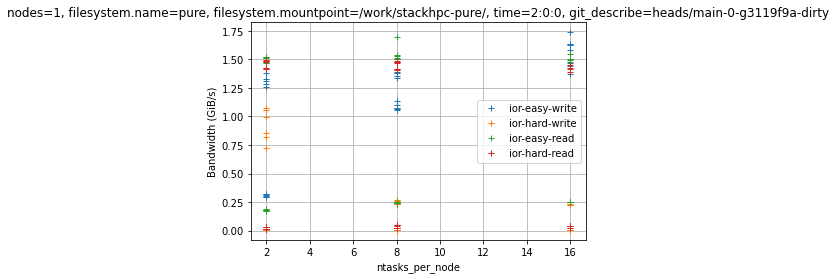

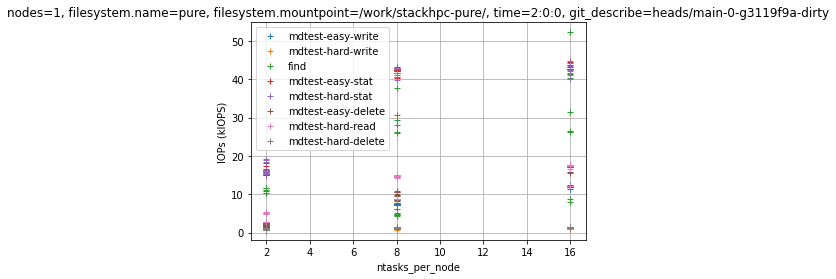

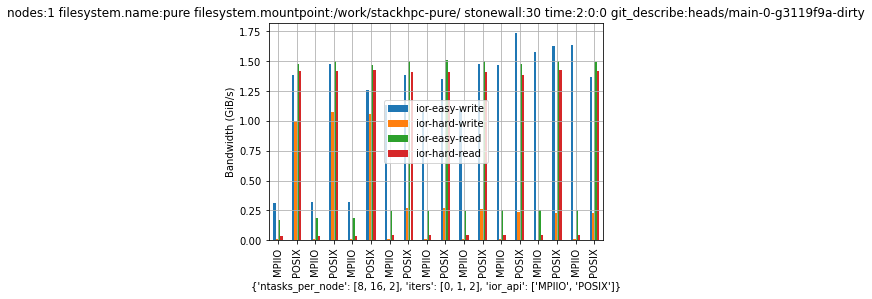

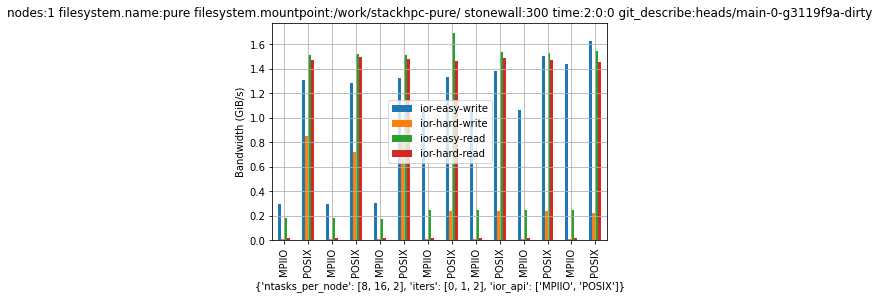

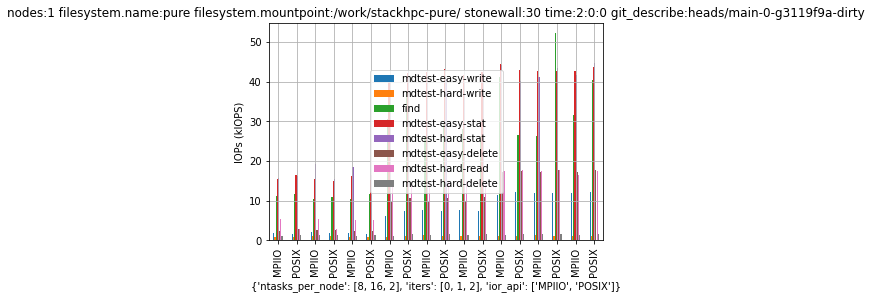

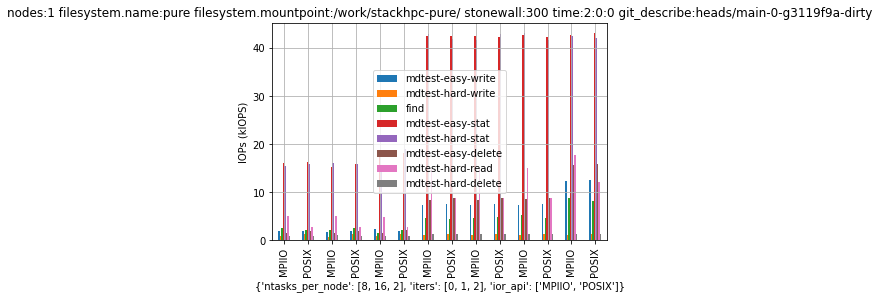

In [39]:
# working
for metric in metrics.values():
    for v, grp_results in metric['results'].groupby('nodes'):
        grp_constants, grp_vars = describe(grp_results[descr_cols])
        grp_common = ', '.join([f'{k}={v}' for k, v in grp_constants.items()])
        grp_results.plot(x='ntasks_per_node', y=metric['cols'], title=grp_common, style='+')
        plt.ylabel(f"{ metric['name'] } ({ metric['unit'] })")
        plt.legend()
        plt.grid()
for metric in metrics.values():
    for v, grp_results in metric['results'].groupby(['stonewall']):
        grp_constants, grp_vars = describe(grp_results[descr_cols])
        grp_common = ' '.join([f'{k}:{v}' for k, v in grp_constants.items()])
        grp_results.plot(x='ior_api', y=metric['cols'], kind='bar',title=str(grp_common), style='+')
        # TODO: tidy this up - trying to show x-plot, plus anything left to vary
        #xlabel = 'ior_api (%s)' % (set(grp_vars.keys()) - set(['ior_api']))
        xlabel = str(grp_vars)
        plt.xlabel(xlabel)
        plt.ylabel(f"{ metric['name'] } ({ metric['unit'] })")
        plt.legend(loc='center')
        plt.grid()